In [1]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from collections import defaultdict
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# If you want to use photos from google drive:
# 1. Open this link https://drive.google.com/drive/folders/1_U3udvWsm1bq6P_m8VUO9jDlGO14zPcl?usp=drive_link
# 2. Go to "Shared with me", right click on shared directory (photos) and click "Organize" -> "Add shortcut" -> "My drive"
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folders_train = {
    "/content/drive/MyDrive/photos/train_val/amsterdam/database/images":"netherlands",
    "/content/drive/MyDrive/photos/train_val/amman/database/images":"jordan",
    "/content/drive/MyDrive/photos/train_val/budapest/database/images":"hungary",
    "/content/drive/MyDrive/photos/train_val/goa/query/images":"india",
    "/content/drive/MyDrive/photos/train_val/moscow/query/images":"russia",
    "/content/drive/MyDrive/photos/train_val/paris/query/images":"france",
    "/content/drive/MyDrive/photos/train_val/zurich/query/images":"switzerland",
    "/content/drive/MyDrive/photos/train_val/nairobi/database/images":"kenya",
    "/content/drive/MyDrive/photos/train_val/ottawa/database/images":"canada",
    "/content/drive/MyDrive/photos/train_val/toronto/database/images":"canada",
    "/content/drive/MyDrive/photos/train_val/trondheim/database/images":"norway",
    "/content/drive/MyDrive/photos/train_val/boston/database/images":"usa",
    "/content/drive/MyDrive/photos/train_val/phoenix/query/images":"usa",
    "/content/drive/MyDrive/photos/train_val/saopaulo/query/images":"brazil",
    "/content/drive/MyDrive/photos/train_val/tokyo/database/images":"japan",
    "/content/drive/MyDrive/photos/test/athens/query/images":"grece",
    "/content/drive/MyDrive/photos/test/bengaluru/query/images":"india",
    "/content/drive/MyDrive/photos/test/kampala/query/images":"uganda",
    "/content/drive/MyDrive/photos/test/stockholm/query/images":"switzerland"
}

country_to_continent = {
  "netherlands": "Europe",
  "jordan": "Asia",
  "hungary": "Europe",
  "india": "Asia",
  "russia": "Europe",
  "france": "Europe",
  "switzerland": "Europe",
  "kenya": "Africa",
  "canada": "North America",
  "norway": "Europe",
  "usa": "North America",
  "brazil": "South America",
  "japan": "Asia",
  "grece": "Europe",
  "uganda": "Africa",
}

def take_images(folders):
  all_image_paths = []
  i = 0
  for folder in folders.keys():
      print("Sprawdzam folder:", folder)
      for root, _, files in os.walk(folder):
          for file in files:
              if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                  full_path = os.path.join(root, file)
                  all_image_paths.append(full_path)
  return all_image_paths

def data_stats(full_train_dataset):
    country_labels = [full_train_dataset.targets_dict[path.rsplit('/', 1)[0]] for path in full_train_dataset.images_paths]
    continent_labels = [country_to_continent[full_train_dataset.targets_dict[path.rsplit('/', 1)[0]]]for path in full_train_dataset.images_paths]

    country_counts = Counter(country_labels)
    continent_counts = Counter(continent_labels)

    print("Liczba zdjęć treningowych:", len(full_train_dataset))
    print("\n")
    for country, count in country_counts.items():
        print(f"{country}: {count} obrazów")
    print("\n")
    for continent, count in continent_counts.items():
        print(f"{continent}: {count} obrazów")

def max_count_country(full_train_dataset):

    country_labels = [full_train_dataset.targets_dict[path.rsplit('/', 1)[0]] for path in full_train_dataset.images_paths]

    country_counts = Counter(country_labels)

    max_count = max([count for country, count in country_counts.items()])
    return max_count

class ImageDataset(Dataset):
    def __init__(self, images_paths, targets_dict, country_to_continent, transform=None):
        self.images_paths = images_paths
        self.transform = transform
        self.targets_dict = targets_dict
        self.country_to_continent = country_to_continent

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = Image.open(image_path).convert("RGB")
        target = self.targets_dict[image_path.rsplit('/',1)[0]]
        general_label = self.country_to_continent[target]

        if self.transform:
            image = self.transform(image)

        return image, target, general_label

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [5]:
# Rest a little, watch some TikToks, it will take up to 10 min
# Ignore warnings about Google Drive
# There are breaks in loading

train_files = take_images(folders_train) # 483601 files

Sprawdzam folder: /content/drive/MyDrive/photos/train_val/amsterdam/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/amman/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/budapest/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/goa/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/moscow/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/paris/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/zurich/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/nairobi/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/ottawa/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/toronto/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/trondheim/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/boston/database/images
Sprawdzam folder: /content/drive/My

Liczba zdjęć treningowych: 483601


Struktura danych
Przykłady zdjęć


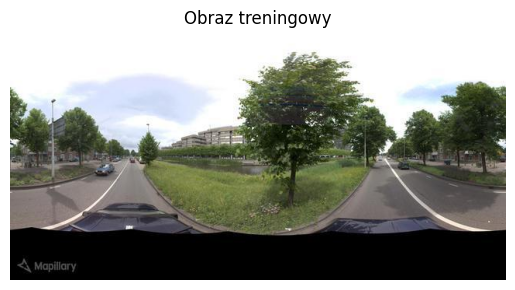

In [6]:
# <-- IMPORTANT INFO -->
# This code is used to investigate data
# You don't have to run it

print("Liczba zdjęć treningowych:", len(train_files))
print("\n")

print("Struktura danych")


print("Przykłady zdjęć")
img = cv2.imread(train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Obraz treningowy")
plt.axis('off')
plt.show()

In [7]:
# <-- IMPORTANT INFO -->
# ImageDataset object returning 3 values - image, label (Country), general_label (continent)

# Important step - normalizing images
full_train_dataset = ImageDataset(train_files, folders_train, country_to_continent, transform=transform)

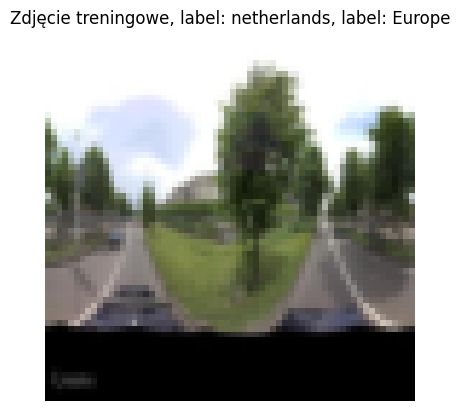

In [8]:
# <-- IMPORTANT INFO -->
# This code is used to investigate data
# You don't have to run it

image_train, label_train, general_label_train = full_train_dataset[0]
image_np_train = image_train.permute(1, 2, 0).numpy()

plt.imshow(image_np_train)
plt.title(f"Zdjęcie treningowe, label: {label_train}, label: {general_label_train}")
plt.axis('off')
plt.show()

In [9]:
data_stats(full_train_dataset)

Liczba zdjęć treningowych: 483601


netherlands: 11539 obrazów
jordan: 953 obrazów
hungary: 153321 obrazów
india: 12388 obrazów
russia: 77496 obrazów
france: 8480 obrazów
switzerland: 9012 obrazów
kenya: 437 obrazów
canada: 82545 obrazów
norway: 5015 obrazów
usa: 64267 obrazów
brazil: 18989 obrazów
japan: 34823 obrazów
grece: 2466 obrazów
uganda: 1870 obrazów


Europe: 267329 obrazów
Asia: 48164 obrazów
Africa: 2307 obrazów
North America: 146812 obrazów
South America: 18989 obrazów


In [10]:
# <-- IMPORTANT INFO -->
# Jak można zobaczyć wyżej mamy problem z równomiernym rozkładem datasetu, szczególnie z danymi z Afryki
# Stworzyliśmy dataset z równomiernym rozkładem zdjęć z danych państw poprzez wyrzucenie losowych danych

In [11]:
# Zanim dane zostaną zredukowane, można spróbować znaleźć inne zbiory danych np. z innych krajów lub dogenerować zdjęcia

#Code with augmentation

In [12]:
max_count = 437

In [13]:
def take_images_with_augmentation(folders,max_count):
  all_image_paths = []
  i = 0
  country_to_folder = {}
  for folder in folders.keys():
      if not folders[folder] in country_to_folder.keys():
          country_to_folder[folders[folder]] = []
      country_to_folder[folders[folder]].append(folder)

  for country in country_to_folder.keys():
      folder_images = []
      for folder in country_to_folder[country]:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')): # Sprawdź rozszerzenia plików obrazów
                    full_path = os.path.join(root, file)
                    folder_images.append(full_path)
      if len(folder_images) < max_count:
          num_to_add = max_count - len(folder_images)
          additional_paths = random.choices(folder_images, k=num_to_add)
          folder_images.extend(additional_paths)
      all_image_paths.extend(folder_images)

  return all_image_paths
#is one of possibility to transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

files_train_augmentation = take_images_with_augmentation(folders_train,max_count)
full_train_dataset_with_augmentation = ImageDataset(files_train_augmentation, folders_train, country_to_continent, transform=train_transform)

In [14]:
data_stats(full_train_dataset_with_augmentation )

Liczba zdjęć treningowych: 483601


netherlands: 11539 obrazów
jordan: 953 obrazów
hungary: 153321 obrazów
india: 12388 obrazów
russia: 77496 obrazów
france: 8480 obrazów
switzerland: 9012 obrazów
kenya: 437 obrazów
canada: 82545 obrazów
norway: 5015 obrazów
usa: 64267 obrazów
brazil: 18989 obrazów
japan: 34823 obrazów
grece: 2466 obrazów
uganda: 1870 obrazów


Europe: 267329 obrazów
Asia: 48164 obrazów
Africa: 2307 obrazów
North America: 146812 obrazów
South America: 18989 obrazów


In [15]:
def show_image(image_, label_, general_label_):
  image_np_train = image_.permute(1, 2, 0).numpy()
  plt.imshow(image_np_train)
  plt.title(f"Zdjęcie treningowe, label: {label_}, label: {general_label_}")
  plt.axis('off')
  plt.show()

In [16]:
train_len = int(0.8 * len(full_train_dataset_with_augmentation))
val_len = len(full_train_dataset_with_augmentation) - train_len
train_dataset, val_dataset_paths = random_split(full_train_dataset_with_augmentation, [train_len, val_len]) # Zwróć uwagę, że walidacyjny zbiór danych na tym etapie nie ma transformacji walidacyjnych

val_image_paths = [files_train_augmentation[i] for i in val_dataset_paths.indices]

val_dataset = ImageDataset(
    val_image_paths,
    targets_dict=full_train_dataset_with_augmentation.targets_dict,
    country_to_continent=full_train_dataset_with_augmentation.country_to_continent,
    transform=transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)

In [17]:
print("Liczba zdjęć treningowych:", len(train_dataset))
print("Liczba zdjęć walidacyjnych:", len(val_dataset))

Liczba zdjęć treningowych: 386880
Liczba zdjęć walidacyjnych: 96721


In [18]:
# Przycinanie danych

# 1. Zgrupuj indeksy po krajach
country_to_indices = defaultdict(list)

for idx, path in enumerate(full_train_dataset_with_augmentation.images_paths):
    country = full_train_dataset_with_augmentation.targets_dict[path.rsplit("/", 1)[0]]
    country_to_indices[country].append(idx)

# 2. Znajdź minimalną liczbę zdjęć dla kraju
min_count = min(len(indices) for indices in country_to_indices.values()) - 137
print(f"Minimalna liczba zdjęć w kraju: {min_count}")

# 3. Wybierz losowo min_count zdjęć z każdego kraju
balanced_indices = []

for indices in country_to_indices.values():
    balanced_indices.extend(random.sample(indices, min_count))

# 4. Zbuduj nową listę ścieżek
balanced_image_paths = [full_train_dataset_with_augmentation.images_paths[i] for i in balanced_indices]

# 5. Utwórz nowy zbalansowany ImageDataset
balanced_train_dataset = ImageDataset(
    balanced_image_paths,
    targets_dict=full_train_dataset_with_augmentation.targets_dict,
    country_to_continent=full_train_dataset_with_augmentation.country_to_continent,
    transform=full_train_dataset_with_augmentation.transform
)

print(f"Liczba obrazów po undersamplingu: {len(balanced_train_dataset)}")

Minimalna liczba zdjęć w kraju: 300
Liczba obrazów po undersamplingu: 4500


In [19]:
data_stats(balanced_train_dataset)

Liczba zdjęć treningowych: 4500


netherlands: 300 obrazów
jordan: 300 obrazów
hungary: 300 obrazów
india: 300 obrazów
russia: 300 obrazów
france: 300 obrazów
switzerland: 300 obrazów
kenya: 300 obrazów
canada: 300 obrazów
norway: 300 obrazów
usa: 300 obrazów
brazil: 300 obrazów
japan: 300 obrazów
grece: 300 obrazów
uganda: 300 obrazów


Europe: 2100 obrazów
Asia: 900 obrazów
Africa: 600 obrazów
North America: 600 obrazów
South America: 300 obrazów


In [20]:
# Split data to training dataset and validation dataset
train_len = int(0.8 * len(balanced_train_dataset))
val_len = len(balanced_train_dataset) - train_len
train_dataset, val_dataset = random_split(balanced_train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

num_epochs = 10

In [21]:
print("Liczba zdjęć treningowych:", len(train_dataset))
print("Liczba zdjęć walidacyjnych:", len(val_dataset))

Liczba zdjęć treningowych: 3600
Liczba zdjęć walidacyjnych: 900


# OCR tablic rejestracyjnych

pretrained model: https://www.kaggle.com/datasets/noepinefrin/yolov8-plate-detection-model-and-fine-tuned?resource=download <br/>
License Plate Detection: https://medium.com/@mahijain9211/license-plate-detection-from-video-files-using-yolo-and-easyocr-6b647f0c94d5

In [22]:
!pip install opencv-python ultralytics easyocr Pillow numpy

In [23]:
import cv2
from ultralytics import YOLO
import easyocr
from PIL import Image
import numpy as np
import logging


# EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

# YOLO model pretrained on license plate images
model = YOLO('/content/license_plates_YOLO_model.pt', task='detect')

# logger level to disable unnecessary printouts
logging.getLogger("ultralytics").setLevel(logging.ERROR)

In [48]:
def look_for_license_plates(img, display_photo=True):

  img_copy = cv2.resize(img, (640, 480)) # resize to 640x480

  results = model.predict(source=img_copy, verbose=False) # make predictions on the current frame

  # iterate over results and draw predictions
  for result in results:
    boxes = result.boxes # boxes predicted by the model
    for box in boxes:
      class_id = int(box.cls) # class ID
      confidence = box.conf.item() # confidence score
      coordinates = box.xyxy[0] # box coordinates as a tensor

      # Extract and convert box coordinates to integers
      x1, y1, x2, y2 = map(int, coordinates.tolist())

      # Draw the box on the frame
      cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

      # Try to apply OCR on detected region
      try:
        # Ensure coordinates are within frame bounds
        r0 = max(0, x1)
        r1 = max(0, y1)
        r2 = min(img_copy.shape[1], x2)
        r3 = min(img_copy.shape[0], y2)

        # Crop license plate region
        plate_region = img_copy[r1:r3, r0:r2]

        # Convert to format compatible with EasyOCR
        plate_image = Image.fromarray(cv2.cvtColor(plate_region, cv2.COLOR_BGR2RGB))
        plate_array = np.array(plate_image)

        # to improve OCR performance, upscaling could be applied here

        # Use EasyOCR to read text from plate
        plate_number = reader.readtext(plate_array)
        concat_number = ' '.join([number[1] for number in plate_number])
        number_conf = np.mean([number[2] for number in plate_number])

        # Draw the detected text on the frame
        # cv2.putText(
        #   img=img_copy,
        #   text=f"Plate: {concat_number} ({number_conf:.2f})",
        #   org=(r0, r1 - 10),
        #   fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        #   fontScale=0.7,
        #   color=(0, 0, 255),
        #   thickness=2
        # )

      except Exception as e:
        print(f"OCR Error: {e}")

    # Show the frame with detections
    if display_photo:
      plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
      plt.show()

    # true if any license plates found, false otherwise
  return len(boxes)>0

In [25]:
closeup = [
    '/content/license_plates/closeup1.jpg',
    '/content/license_plates/closeup2.jpg',
    '/content/license_plates/closeup3.jpg',
]

dashcam = [
    '/content/license_plates/dashcam1.jpg',
    '/content/license_plates/dashcam2.jpg',
    '/content/license_plates/dashcam3.jpg',
    '/content/license_plates/dashcam4.jpg',
    '/content/license_plates/dashcam5.jpg',
    '/content/license_plates/dashcam6.jpg',
    '/content/license_plates/dashcam7.jpeg',
    '/content/license_plates/dashcam8.jpeg',
    '/content/license_plates/dashcam9.jpg',
]

plates = [
    '/content/license_plates/eu.jpg',
    '/content/license_plates/usa.jpg',
    '/content/license_plates/eu_usa.png'
]

traffic = [
    '/content/license_plates/traffic_1.jpg',
    '/content/license_plates/traffic_2.jpg',
    '/content/license_plates/traffic_3.jpg',
    '/content/license_plates/traffic_4.jpg',
]

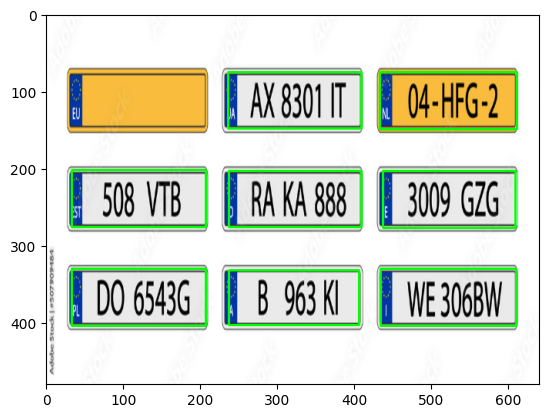

License plate was found



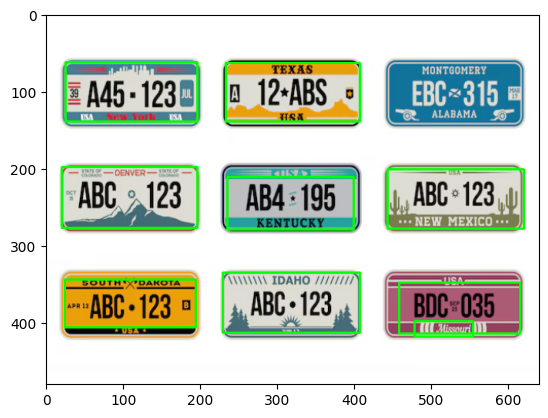

License plate was found



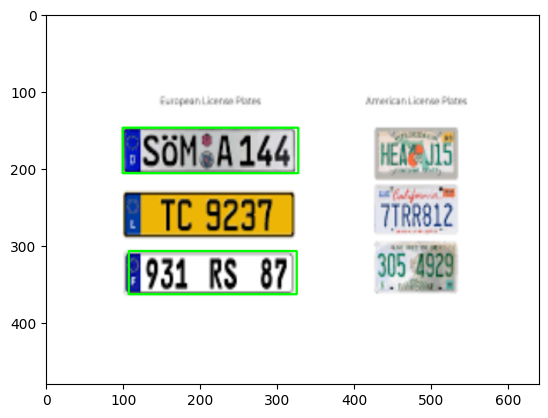

License plate was found



In [49]:
for path in plates:
  frame = cv2.imread(path)
  found_license_plate = look_for_license_plates(frame)
  print(f"License plate was {'NOT ' if not found_license_plate else ''}found\n")

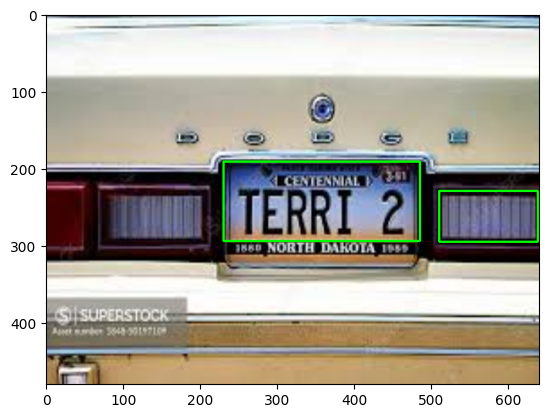

License plate was found



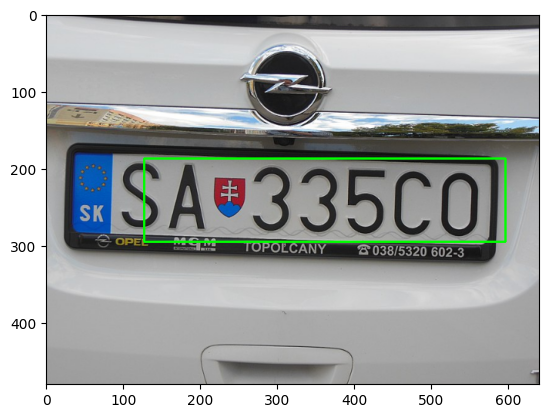

License plate was found



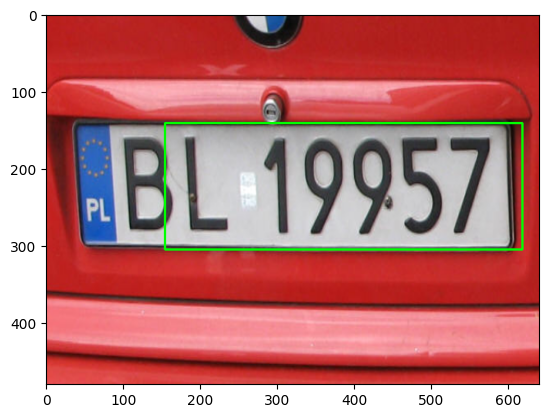

License plate was found



In [50]:
for path in closeup:
  frame = cv2.imread(path)
  found_license_plate = look_for_license_plates(frame)
  print(f"License plate was {'NOT ' if not found_license_plate else ''}found\n")

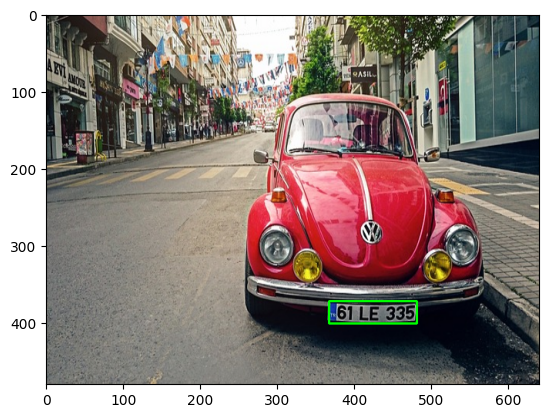

License plate was found



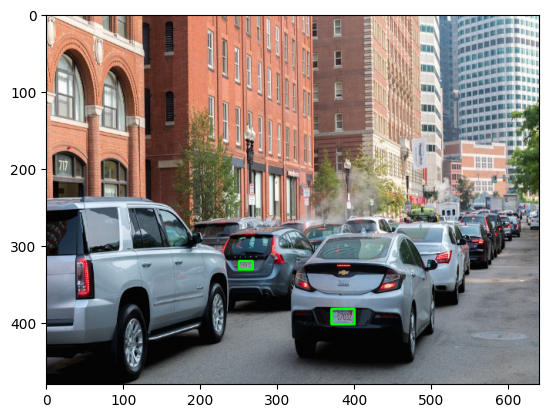

License plate was found



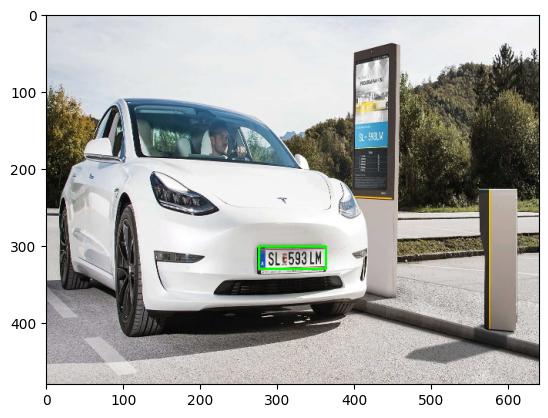

License plate was found



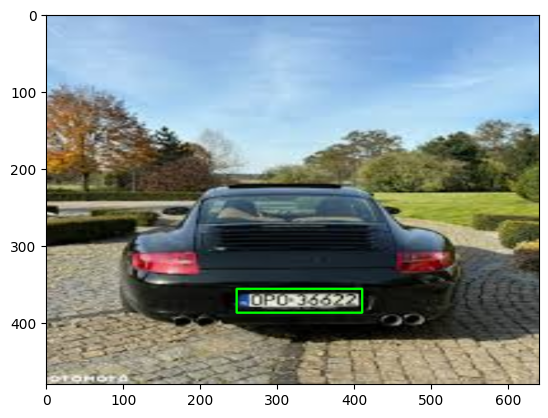

License plate was found



In [51]:
for path in traffic:
  frame = cv2.imread(path)
  found_license_plate = look_for_license_plates(frame)
  print(f"License plate was {'NOT ' if not found_license_plate else ''}found\n")

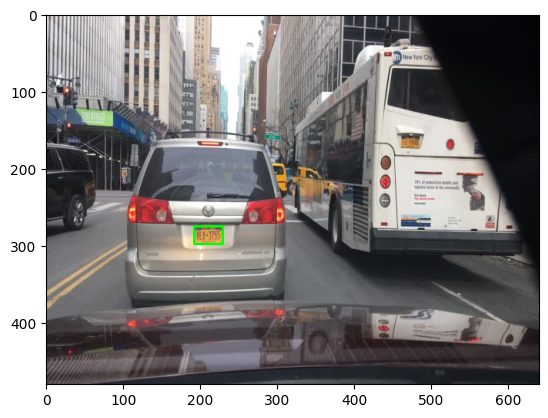

License plate was found



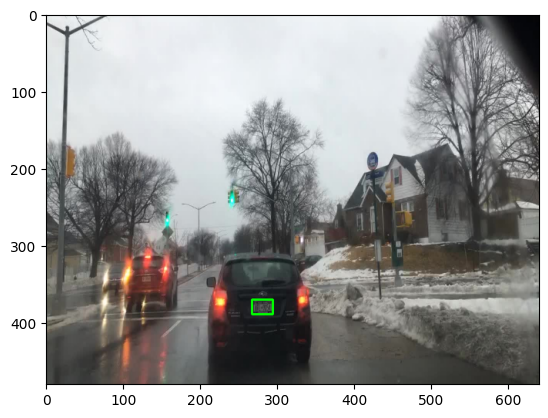

License plate was found



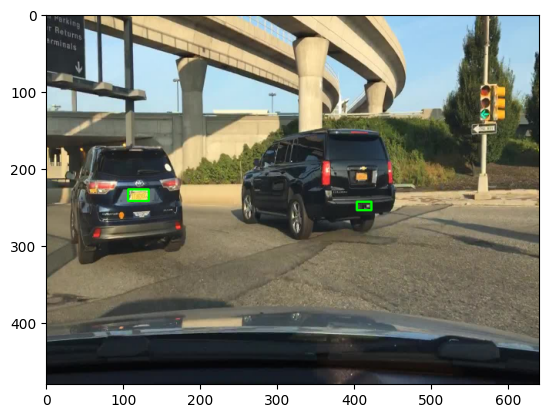

License plate was found



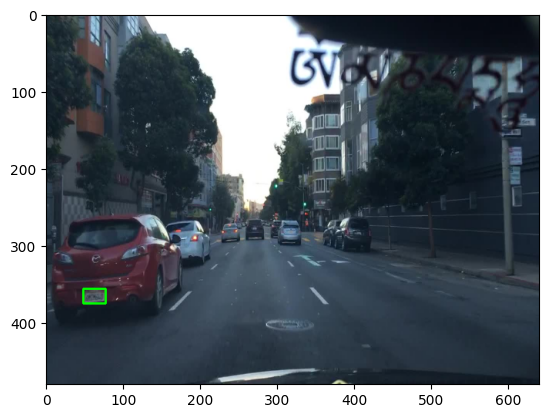

License plate was found



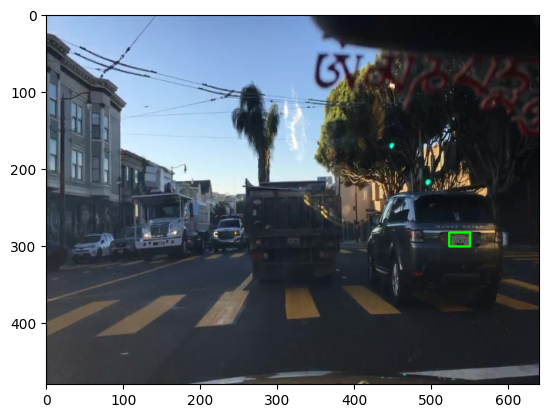

License plate was found



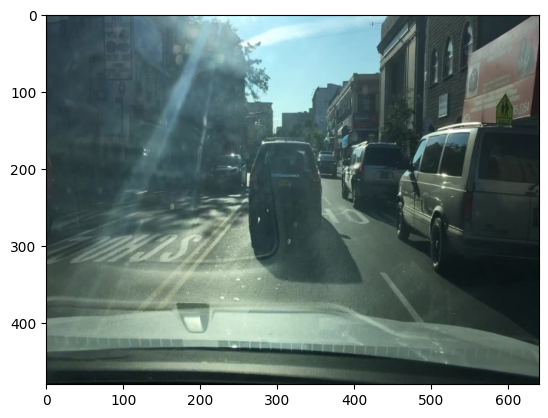

License plate was NOT found



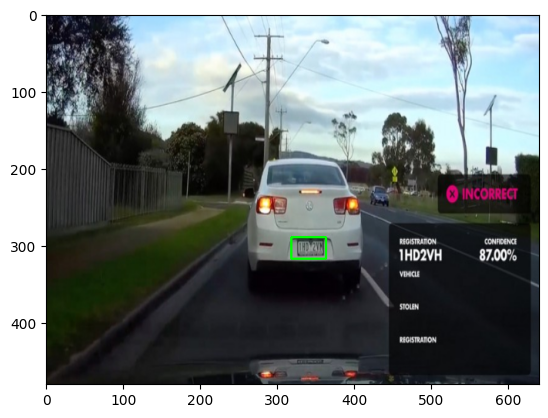

License plate was found



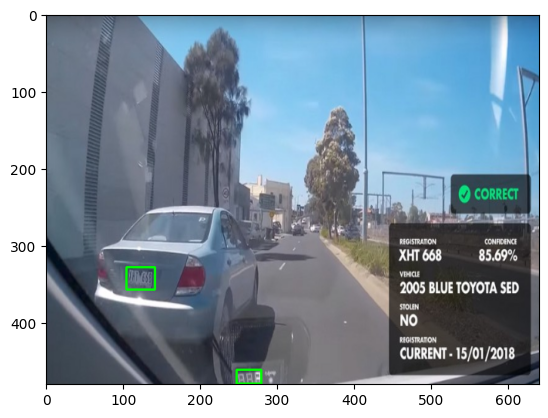

License plate was found



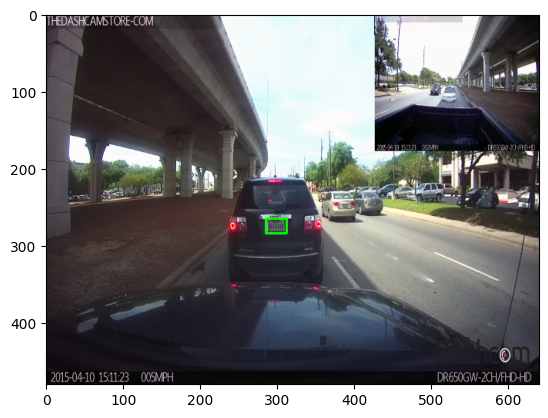

License plate was found



In [52]:
for path in dashcam:
  frame = cv2.imread(path)
  found_license_plate = look_for_license_plates(frame)
  print(f"License plate was {'NOT ' if not found_license_plate else ''}found\n")

In [61]:
import random

# generated random indexes to test on dataset
random_indexes = random.sample(range(0, len(train_files)), 10)
print(random_indexes)

[369792, 357233, 246907, 69260, 137622, 421179, 446622, 287829, 437414, 374043]


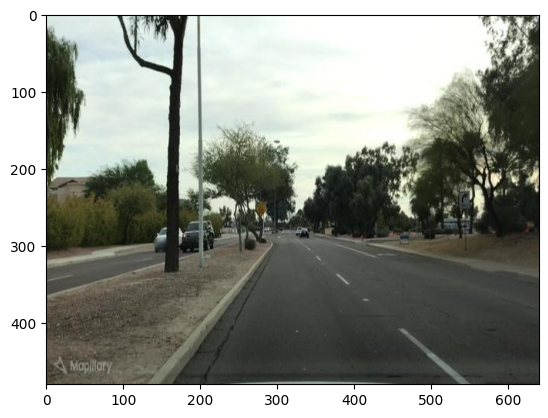

License plate was NOT found



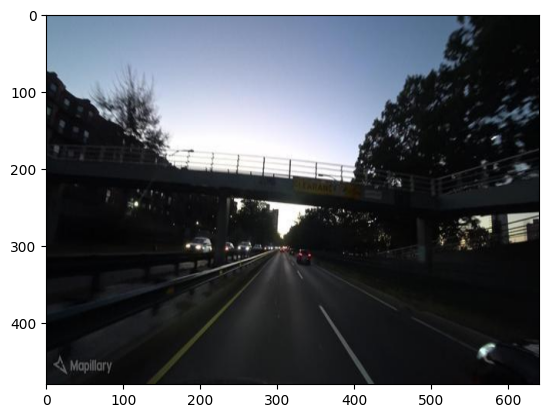

License plate was NOT found



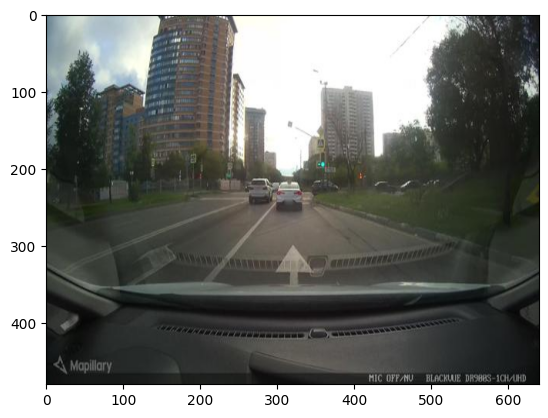

License plate was NOT found



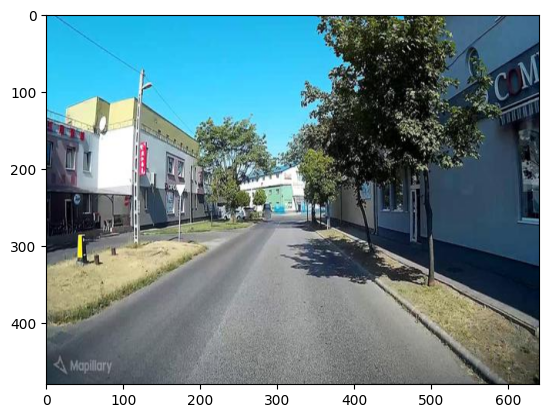

License plate was NOT found



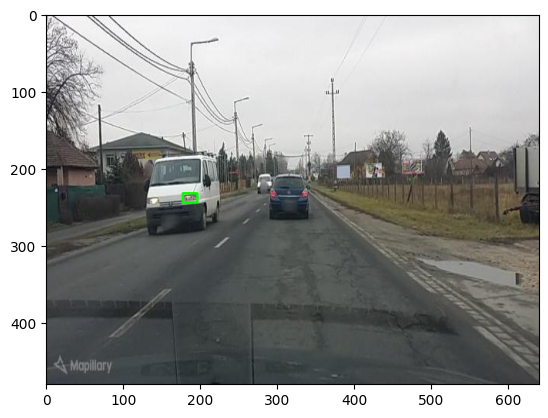

License plate was found



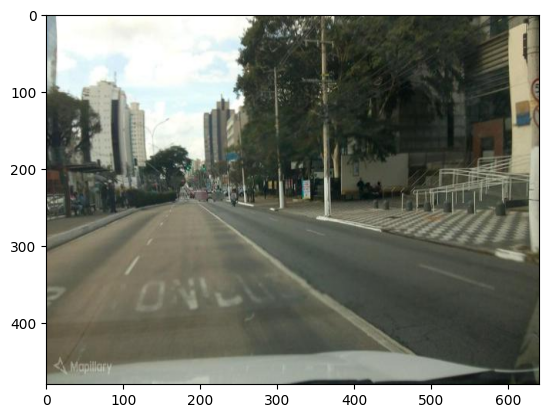

License plate was NOT found



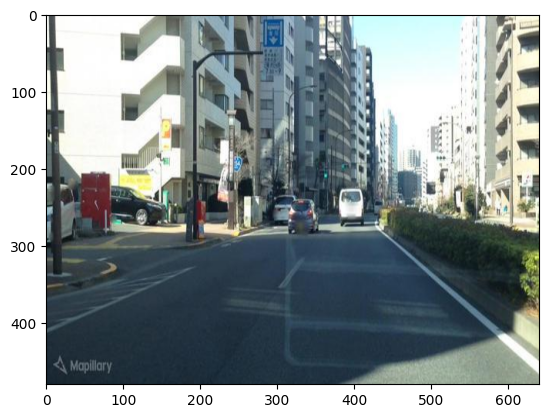

License plate was NOT found



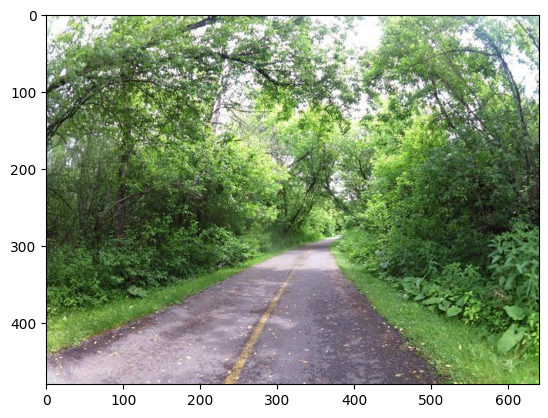

License plate was NOT found



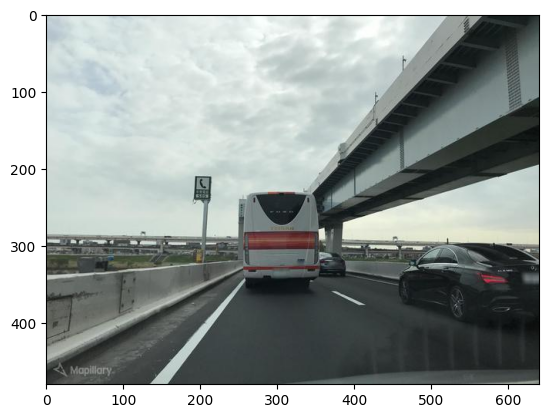

License plate was NOT found



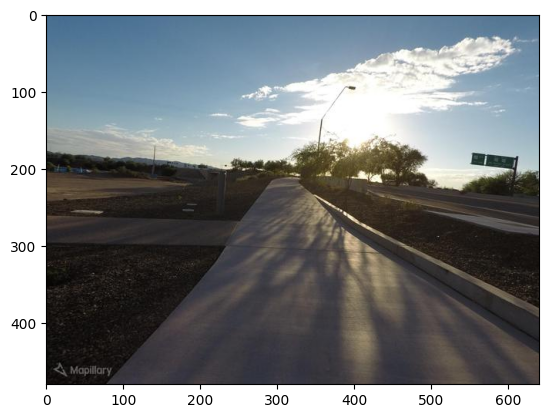

License plate was NOT found



In [62]:
for i in random_indexes:
  frame = cv2.imread(train_files[i])
  found_license_plate = look_for_license_plates(frame)
  print(f"License plate was {'NOT ' if not found_license_plate else ''}found\n")

In [63]:
sample_size = 1000
random_indexes = random.sample(range(0, len(train_files)), sample_size)

In [64]:
# check sample of 1000 random images from dataset, whether they include license plates
number_of_img_w_plate = 0

for i in random_indexes:
  frame = cv2.imread(train_files[i])
  found_license_plate = look_for_license_plates(frame, display_photo=False)
  if found_license_plate:
    number_of_img_w_plate += 1

print(f'License plate was found in {number_of_img_w_plate}/{sample_size} photos ({number_of_img_w_plate/sample_size*100:.2f}%)')

License plate was found in 69/1000 photos (6.90%)
